# Configuração da Sessão





In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

path = '/content/gdrive/MyDrive/IBM/PySpark/Projeto_202208/data'

Mounted at /content/gdrive


In [ ]:
!pip install pyspark

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import pandas as pd

spark = SparkSession \
  .builder \
  .appName("Python Spark create RDD example") \
  .config("spark.some.config.option", "some-value") \
  .getOrCreate()

# Carregamento dos datasets

## Covid

In [ ]:
df_covid = spark.read.csv(path=f'{path}/owid-covid-data.csv',
  # sep=',',
  # encoding='UTF-8',
  # comment=None,
  header=True,
  inferSchema=True)

## Gasto com Saúde

In [ ]:
df_saude = spark.read.csv(path=f'{path}/public-health-expenditure-share-GDP-OWID.csv',
  # sep=',',
  # encoding='UTF-8',
  # comment=None,
  header=True,
  inferSchema=True)

## Indíce Gini

In [ ]:
df_gini = spark.read.csv(path=f'{path}/gini.csv',
  # sep=',',
  # encoding='UTF-8',
  # comment=None,
  header=True,
  inferSchema=True)

# Análise COVID


#### Visualizar lugares (coluna location) com continente nulo

In [ ]:
df_covid.filter("continent is null").select("iso_code", "continent", "location").distinct().show()

+--------+---------+-------------------+
|iso_code|continent|           location|
+--------+---------+-------------------+
|OWID_LMC|     null|Lower middle income|
|OWID_LIC|     null|         Low income|
|OWID_INT|     null|      International|
|OWID_ASI|     null|               Asia|
|OWID_EUR|     null|             Europe|
|OWID_EUN|     null|     European Union|
|OWID_HIC|     null|        High income|
|OWID_AFR|     null|             Africa|
|OWID_OCE|     null|            Oceania|
|OWID_SAM|     null|      South America|
|OWID_WRL|     null|              World|
|OWID_NAM|     null|      North America|
|OWID_UMC|     null|Upper middle income|
+--------+---------+-------------------+



#### Criar coluna com mês / ano

In [ ]:
df_covid = df_covid.withColumn("month_year", date_format(col("date"), "yyyyMM")) \
            .withColumn("year", date_format(col("date"), "yyyy"))

#### Top 10 países com mais mortes 

In [ ]:
df_covid \
  .filter("continent is not null") \
  .groupBy(col("location")) \
  .agg(round(sum("new_deaths"), 2).alias('soma'), \
        round(avg("new_deaths"), 2).alias('media'), \
        round(max("new_deaths"), 2).alias('maximo'), \
        round(min("new_deaths"), 2).alias('minimo')   \
    ) \
    .orderBy(col('soma').desc()) \
    .show(10)

+--------------+---------+-------+------+------+
|      location|     soma|  media|maximo|minimo|
+--------------+---------+-------+------+------+
| United States|1041427.0|1152.02|4411.0|   0.0|
|        Brazil| 682632.0|  769.6|4148.0|   0.0|
|         India| 520043.0| 582.35|4529.0|   0.0|
|United Kingdom| 408128.0| 437.44|2976.0|   0.0|
|        Russia| 375845.0| 423.73|1222.0|   0.0|
|        Mexico| 321826.0| 366.13|3050.0|   0.0|
|          Peru| 216115.0| 240.93|1234.0|   0.0|
|         Italy| 174828.0| 191.49| 993.0|   1.0|
|     Indonesia| 157396.0| 175.86|2069.0|   0.0|
|        France| 154073.0| 168.75|1438.0|   0.0|
+--------------+---------+-------+------+------+
only showing top 10 rows



#### Top 10 países com mais mortes por milhão

In [ ]:
df_covid \
  .filter("continent is not null") \
  .groupBy(col("location")) \
  .agg(round(sum("new_deaths_per_million"), 2).alias('soma'), \
        round(avg("new_deaths_per_million"), 2).alias('media'), \
        round(max("new_deaths_per_million"), 2).alias('maximo'), \
        round(min("new_deaths_per_million"), 2).alias('minimo')   \
    ) \
    .orderBy(col('soma').desc()) \
    .na.drop() \
    .show(10)

+--------------------+-------+-----+------+------+
|            location|   soma|media|maximo|minimo|
+--------------------+-------+-----+------+------+
|                Peru|6409.96| 7.15|  36.6|   0.0|
|      United Kingdom|6066.02|  6.5| 44.23|   0.0|
|            Bulgaria|5454.63| 6.09| 48.51|   0.0|
|Bosnia and Herzeg...|4897.06| 5.55| 63.29|   0.0|
|             Hungary|4849.06| 5.47| 50.36|   0.0|
|     North Macedonia|4492.85| 5.08| 24.25|   0.0|
|             Georgia|4492.58| 5.16| 22.89|   0.0|
|          Montenegro|4408.63|  5.0| 28.67|   0.0|
|             Croatia|4083.36|  4.6| 22.66|   0.0|
|             Czechia|3879.52| 4.45| 38.44|   0.0|
+--------------------+-------+-----+------+------+
only showing top 10 rows



#### Selecionar conjunto de países para análise mais detalhada

In [ ]:
df_covid_filtered = df_covid.filter(upper(col("location")).rlike('BRAZIL|ARGENTINA|GERMANY|CANADA|UNITED KINGDOM|ITALY'))

In [ ]:
df_covid_filtered.select("iso_code", "location").distinct().show(20, False)

+--------+--------------+
|iso_code|location      |
+--------+--------------+
|ITA     |Italy         |
|BRA     |Brazil        |
|DEU     |Germany       |
|ARG     |Argentina     |
|CAN     |Canada        |
|GBR     |United Kingdom|
+--------+--------------+



## Realizar join entre datasets

### Dataset de Gasto com Saúde

In [ ]:
df_saude.printSchema()

root
 |-- Entity: string (nullable = true)
 |-- Code: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- public_health_expenditure_pc_gdp: double (nullable = true)



#### Selecionar países

In [ ]:
df_saude_filtered = df_saude.filter(upper(col("Entity")).rlike('BRAZIL|ARGENTINA|GERMANY|CANADA|UNITED KINGDOM|ITALY'))

#### Transformar dataset para visualização

In [ ]:
def createColumns(colname):
  return pd_df_saude_filtered['public_health_expenditure_pc_gdp'][pd_df_saude_filtered['Code'] == colname]

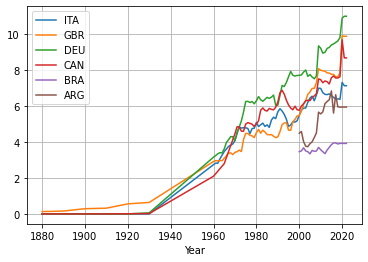

In [ ]:
pd_df_saude_filtered = df_saude_filtered.toPandas()
pd_df_saude_filtered = pd_df_saude_filtered.set_index('Year', drop=True)

pd_df_saude_transformed= pd.DataFrame()

for column in pd_df_saude_filtered['Code'].sort_values(ascending=False).unique():
  pd_df_saude_transformed[column] = createColumns(column)

pd_df_saude_transformed.loc[2022] = None
pd_df_saude_transformed = pd_df_saude_transformed.fillna(method='ffill')
pd_df_saude_transformed.plot(grid=True)

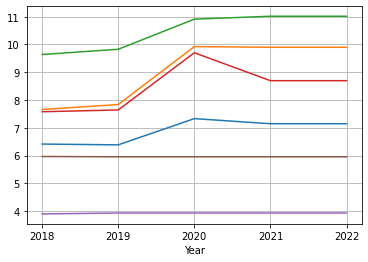

In [ ]:
pd_df_saude_transformed[pd_df_saude_transformed.index >= 2018].plot(grid=True, legend=False, xticks=[2018, 2019, 2020, 2021, 2022])

In [ ]:
pd_df_saude_transformed = pd_df_saude_transformed.stack().reset_index()
pd_df_saude_transformed.columns = ['year', 'iso_code', 'health_investment']

In [ ]:
df_saude_transformed = spark.createDataFrame(pd_df_saude_transformed) 

#### Join com o dataset de gastos de saúde

In [ ]:
df_join = df_covid_filtered.join(df_saude_transformed, ["year", "iso_code"] ,"inner")

In [ ]:
df_join.show()

+----+--------+-------------+--------+-------------------+-----------+---------+------------------+------------+----------+-------------------+-----------------------+---------------------+------------------------------+------------------------+----------------------+-------------------------------+-----------------+------------+------------------------+-------------+-------------------------+---------------------+---------------------------------+----------------------+----------------------------------+-----------+---------+------------------------+----------------------+------------------+-------------------------------+-------------+--------------+---------------+------------------+-----------------+-----------------------+--------------+----------------+-------------------------+------------------------------+-----------------------------+-----------------------------------+--------------------------+-------------------------------------+------------------------------+------------

In [ ]:
df_join.count()

5627

### Dataset do indice Gini

In [ ]:
df_gini.show(5)

+--------------------+------------+--------------+--------------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+
|        Country Name|Country Code|Indicator Name|Indicator Code|1960|1961|1962|1963|1964|1965|1966|1967|1968|1969|1970|1971|1972|1973|1974|1975|1976|1977|1978|1979|1980|1981|1982|1983|1984|1985|1986|1987|1988|1989|1990|1991|1992|1993|1994|1995|1996|1997|1998|1999|2000|2001|2002|2003|2004|2005|2006|2007|2008|2009|2010|2011|2012|2013|2014|2015|2016|2017|2018|2019|2020|2021|_c66|
+--------------------+------------+--------------+--------------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+---

In [ ]:
df_gini_filtered = df_gini.filter(upper(col("Country Name")).rlike('BRAZIL|ARGENTINA|GERMANY|CANADA|UNITED KINGDOM|ITALY'))

In [ ]:
for field in df_gini_filtered.schema.fields:
  df_gini_filtered = df_gini_filtered.withColumnRenamed(field.name ,field.name.replace(" ", "_").lower())

In [ ]:
df_gini_filtered.show(5)

+--------------+------------+--------------+--------------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+
|  country_name|country_code|indicator_name|indicator_code|1960|1961|1962|1963|1964|1965|1966|1967|1968|1969|1970|1971|1972|1973|1974|1975|1976|1977|1978|1979|1980|1981|1982|1983|1984|1985|1986|1987|1988|1989|1990|1991|1992|1993|1994|1995|1996|1997|1998|1999|2000|2001|2002|2003|2004|2005|2006|2007|2008|2009|2010|2011|2012|2013|2014|2015|2016|2017|2018|2019|2020|2021|_c66|
+--------------+------------+--------------+--------------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-

In [ ]:
pd_df_gini_filtered = df_gini_filtered.toPandas()
pd_df_gini_filtered = pd_df_gini_filtered.drop(columns=['country_name', 'indicator_name', 'indicator_code'])
pd_df_gini_filtered = pd_df_gini_filtered.set_index('country_code')
pd_df_gini_filtered = pd_df_gini_filtered.stack().reset_index()
pd_df_gini_filtered.columns = ['iso_code', 'year', 'gini']
pd_df_gini_filtered['year'] = pd_df_gini_filtered['year'].astype(int)

In [ ]:
pd_df_gini_filtered = pd_df_gini_filtered.set_index(['iso_code', 'year'])

In [ ]:
for code in pd_df_gini_filtered.reset_index()['iso_code'].unique().tolist():
  year = pd_df_gini_filtered.loc[(code)].index.max()
  for i in range(3):
    pd_df_gini_filtered.loc[(code, 2020+i), 'gini'] = pd_df_gini_filtered.loc[(code, year), 'gini']

In [ ]:
df_gini_transformed = spark.createDataFrame(pd_df_gini_filtered.reset_index()) 

In [ ]:
df_join = df_join.join(df_gini_transformed, ["year", "iso_code"] ,"left")

In [ ]:
df_join.show(5)

+----+--------+-------------+--------+-------------------+-----------+---------+------------------+------------+----------+-------------------+-----------------------+---------------------+------------------------------+------------------------+----------------------+-------------------------------+-----------------+------------+------------------------+-------------+-------------------------+---------------------+---------------------------------+----------------------+----------------------------------+-----------+---------+------------------------+----------------------+------------------+-------------------------------+-------------+--------------+---------------+------------------+-----------------+-----------------------+--------------+----------------+-------------------------+------------------------------+-----------------------------+-----------------------------------+--------------------------+-------------------------------------+------------------------------+------------

## Conhecer os países

In [ ]:
df_join.select("location", "population", "human_development_index", "health_investment", "gini") \
                  .filter('year = 2020') \
                  .distinct() \
                  .orderBy(col('gini').desc()) \
                  .show()

+--------------+------------+-----------------------+-----------------+----+
|      location|  population|human_development_index|health_investment|gini|
+--------------+------------+-----------------------+-----------------+----+
|        Brazil|2.14326223E8|                  0.765|             3.93|48.9|
|     Argentina|  4.527678E7|                  0.845|            5.954|42.3|
|         Italy|  5.924033E7|                  0.892|            7.329|35.2|
|United Kingdom|  6.728104E7|                  0.932|            9.923|35.1|
|        Canada| 3.8155012E7|                  0.929|            9.701|33.3|
|       Germany| 8.3408554E7|                  0.947|           10.911|31.7|
+--------------+------------+-----------------------+-----------------+----+



## Investigar possíveis correlações

In [ ]:
df_join.createOrReplaceTempView("df_join")

### Correlação casos, óbitos e pessoas vacinadas

In [ ]:
pd_df_deaths_vaccinations = spark.sql('''
  select  location, month_year, COALESCE(SUM(total_deaths), 0) total_deaths, COALESCE(SUM(people_vaccinated), 0) people_vaccinated, COALESCE(SUM(total_cases), 0) total_cases
  from df_join
  group by location, month_year
  order by location, month_year
  ''').toPandas()

In [ ]:
pd_df_deaths_vaccinations = pd_df_deaths_vaccinations.set_index(['location', 'month_year'])

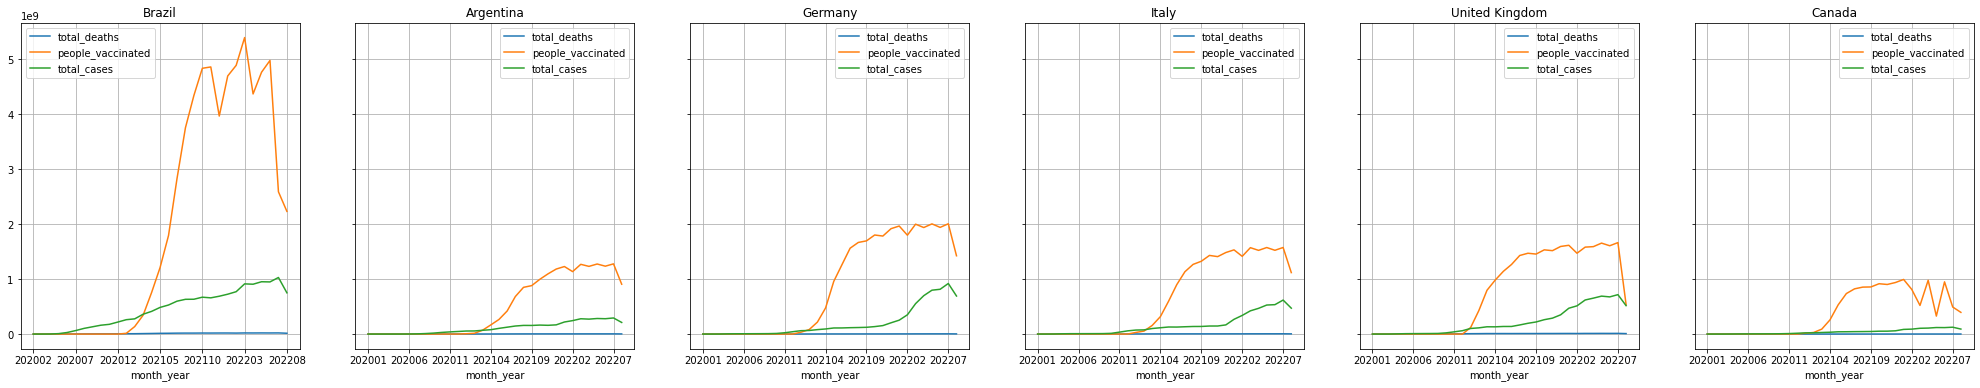

In [ ]:
import matplotlib.pyplot as plt

fig, (ax, ax2, ax3, ax4, ax5, ax6) = plt.subplots(ncols=6, sharey=True,figsize=(35,6))
pd_df_deaths_vaccinations.loc['Brazil'].plot(title='Brazil', grid=True, ax=ax)
pd_df_deaths_vaccinations.loc['Argentina'].plot(title='Argentina',grid=True, ax=ax2)
pd_df_deaths_vaccinations.loc['Germany'].plot(title='Germany',grid=True, ax=ax3)
pd_df_deaths_vaccinations.loc['Italy'].plot(title='Italy',grid=True, ax=ax4)
pd_df_deaths_vaccinations.loc['United Kingdom'].plot(title='United Kingdom',grid=True, ax=ax5)
pd_df_deaths_vaccinations.loc['Canada'].plot(title='Canada',grid=True, ax=ax6)
plt.show()

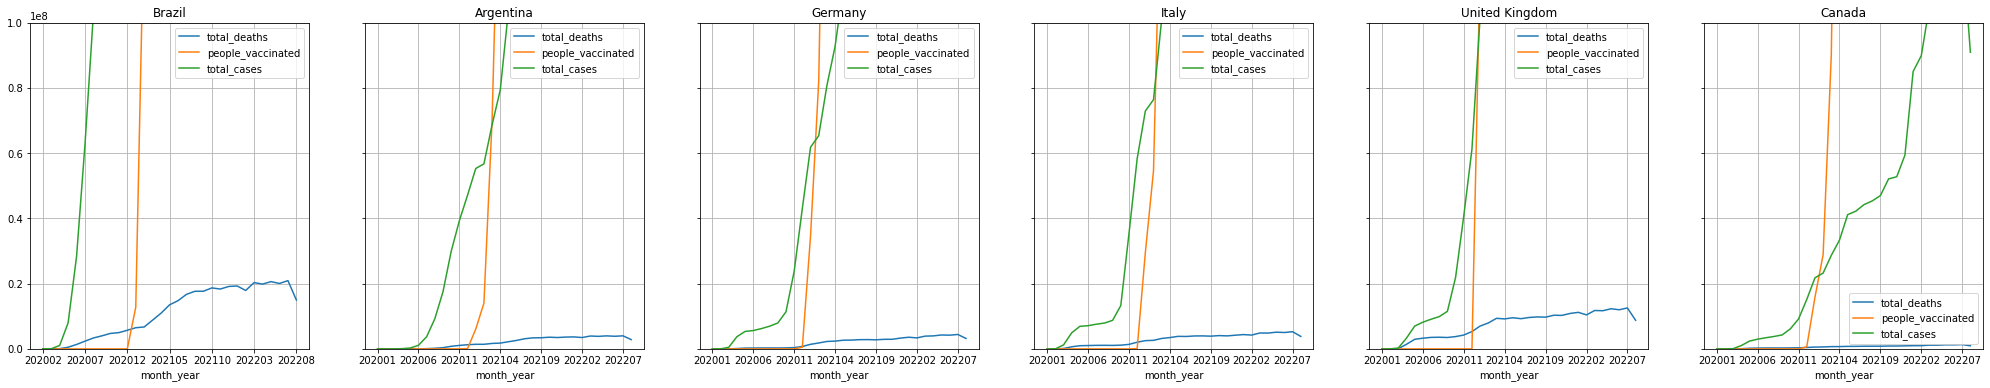

In [ ]:
fig, (ax, ax2, ax3, ax4, ax5, ax6) = plt.subplots(ncols=6, sharey=True,figsize=(35,6))
pd_df_deaths_vaccinations.loc['Brazil'].plot(title='Brazil', grid=True, ax=ax, ylim=(0,100000000))
pd_df_deaths_vaccinations.loc['Argentina'].plot(title='Argentina',grid=True, ax=ax2, ylim=(0,100000000))
pd_df_deaths_vaccinations.loc['Germany'].plot(title='Germany',grid=True, ax=ax3, ylim=(0,100000000))
pd_df_deaths_vaccinations.loc['Italy'].plot(title='Italy',grid=True, ax=ax4, ylim=(0,100000000))
pd_df_deaths_vaccinations.loc['United Kingdom'].plot(title='United Kingdom',grid=True, ax=ax5, ylim=(0,100000000))
pd_df_deaths_vaccinations.loc['Canada'].plot(title='Canada',grid=True, ax=ax6, ylim=(0,100000000))
plt.show()

### Correlação óbitos e investimento em saúde (porcentagem do PIB do país)

In [ ]:
pd_df_health_investment = spark.sql('''
  select location, year, health_investment, sum(total_deaths) total_deaths
  from df_join
  group by location, year, health_investment
  order by location, year
  ''').toPandas()

In [ ]:
pd_df_health_investment = pd_df_health_investment.set_index(['location', 'year'])

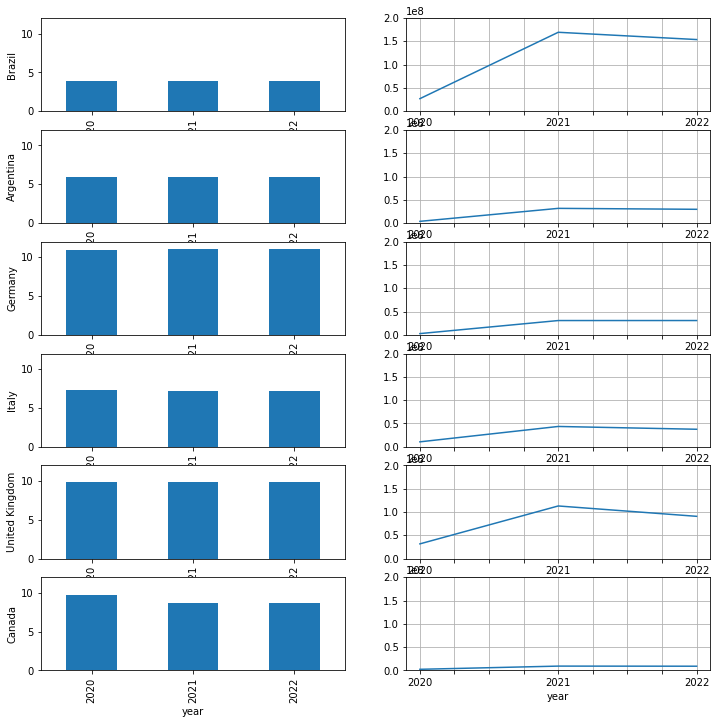

In [ ]:
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(12,12))

health_investment_countries = ['Brazil', 'Argentina', 'Germany', 'Italy', 'United Kingdom', 'Canada']

for i, column in enumerate(axes):
  for j, line in enumerate(column):
    if j % 2 == 0:
      pd_df_health_investment.loc[health_investment_countries[i]]['health_investment'].plot(kind='bar', ax=axes[i][j], ylim=(0,12), ylabel=health_investment_countries[i])
    else:
      pd_df_health_investment.loc[health_investment_countries[i]]['total_deaths'].plot(grid=True, ax=axes[i][j], ylim=(0,200000000))
      
plt.show()

### Correlação entre obitos, indice de desenvolvimento humano e indice de desigualdade (gini)

In [ ]:
# pd_df_health_investment = spark.sql('''
#   select location, year, human_development_index, gini, sum(total_deaths) total_deaths
#   from df_join
#   group by location, year, human_development_index, gini
#   order by location, year
#   ''').toPandas()

pd_df_gini = df_join.groupBy('location', 'year', 'human_development_index', 'gini') \
  .agg(round(sum('total_deaths'), 2).alias('total_deaths'),) \
  .orderBy('location', 'year') \
  .toPandas()

In [ ]:
pd_df_gini = pd_df_gini.set_index(['location', 'year'])

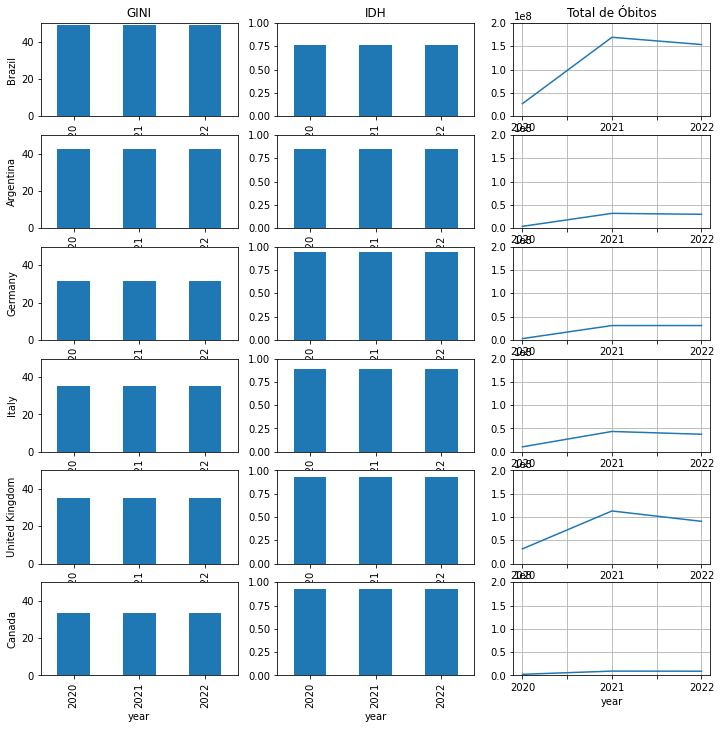

In [ ]:
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(12,12))

for i, column in enumerate(axes):
  for j, line in enumerate(column):
    if j == 0:
        if(i == 0): 
          pd_df_gini.loc[health_investment_countries[i]]['gini'].plot(kind='bar', ax=axes[i][j], ylim=(0,50), ylabel=health_investment_countries[i], title='GINI')
        else:
          pd_df_gini.loc[health_investment_countries[i]]['gini'].plot(kind='bar', ax=axes[i][j], ylim=(0,50), ylabel=health_investment_countries[i])
    elif j == 1:
      if(i == 0): 
        pd_df_gini.loc[health_investment_countries[i]]['human_development_index'].plot(kind='bar', ax=axes[i][j], ylim=(0,1), title='IDH')
      else:
        pd_df_gini.loc[health_investment_countries[i]]['human_development_index'].plot(kind='bar', ax=axes[i][j], ylim=(0,1))
    else:
      if(i == 0):
        pd_df_gini.loc[health_investment_countries[i]]['total_deaths'].plot(grid=True, ax=axes[i][j], ylim=(0,200000000), title='Total de Óbitos')
      else:
        pd_df_gini.loc[health_investment_countries[i]]['total_deaths'].plot(grid=True, ax=axes[i][j], ylim=(0,200000000))
      
plt.show()